<a href="https://colab.research.google.com/github/google/applied-machine-learning-intensive/blob/master/content/05_deep_learning/04_transfer_learning/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Google LLC.

In [6]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer Learning

In the field of deep learning, **transfer learning** is defined as the conveyance of knowledge from one pretrained model to a new model. This simply means that transfer learning uses a pretrained model to train a new model. Typically the new model will have a more specific application than the pre-trained model.

*Note that this lab is largely based on [an excellent transfer learning lab](https://www.tensorflow.org/tutorials/images/transfer_learning) from TensorFlow.*

## Exploratory Data Analysis

The [`tensorflow_datasets`](https://www.tensorflow.org/datasets/api_docs/python/tfds) package has a [catalog of datasets](https://www.tensorflow.org/datasets/catalog/overview) that are easy to load into your TensorFlow environment for experimentation.

In this lab we'll work with the [`cats_vs_dogs`](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset. This dataset contains thousands of images of cats and dogs. Looking at the [documentation for the dataset](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs), we can see there are `23,262` examples in the 'train' split of data. There are no test and validation splits.

We could just load this one split directly and then split the data once we download it. Another option is to tell `tfds.load()` to split the data for us. To do that we must specify the splits.

There is a specific notation we can use that tells the function how much of the data we want in each split. For instance `'train[:80%]'` indicates that we want the first `80%` of the train split in one tranche. `'train[80%:90%]'` indicates that we want the next 10% of the data in another tranche, and so on. You can see this at work in our `split` example below.

In [7]:
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

2022-07-03 01:14:05.285799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The metadata returned from our dataset contains useful information about the data. For instance, it includes the number of classes:

In [8]:
metadata.features['label'].num_classes

2

And the class names:

In [9]:
metadata.features['label'].names

['cat', 'dog']

It even comes with some handy functions for converting between class names and numbers:

In [10]:
print(metadata.features['label'].int2str(1))
print(metadata.features['label'].str2int('cat'))

dog
0


Let's store the `int2str` into a more conveniently named function for later use.

In [11]:
get_class_name = metadata.features['label'].int2str
get_class_name(0), get_class_name(1)

('cat', 'dog')

Let's take a quick look at our dataset. First we'll peek at the shape of the data.

In [12]:
raw_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

`(None, None, 3)` lets us know that we have three channel images, but we aren't sure of the lengths and widths. They are likely different depending on the image. We also don't know how many images we have.

Let's do some deeper analysis.

It turns out that you can iterate over a `DatasetV1Adapter` with a standard `for` loop. The items returned at each iteration are the image and the label.

We'll create a helper function to analyze a split of our data.

In [13]:
import collections


def split_details(split):
  counts = collections.defaultdict(int)
  for image, label in split:
    counts[label.numpy()]+=1

  total = 0
  for cls, cnt in counts.items():
    print(f"Class {get_class_name(cls)}: {cnt}")
    total += cnt
  
  print(f"Total: {total}")

for s in (
    ("Train", raw_train),
    ("Validation", raw_validation),
    ("Test", raw_test)):
  print(s[0])
  split_details(s[1])
  print()

Train


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Class dog: 9232
Class cat: 9378
Total: 18610

Validation


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


Class dog: 1206
Class cat: 1120
Total: 2326

Test


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Class cat: 1160
Class dog: 1166
Total: 2326



We'll train on `18,610` examples, validating on `2,326`, and performing our final testing on `2,326`. Our classes look pretty evenly spread across all of the splits. The classes also seem to have a similar number of total examples.

Let's now see what our images look like. We'll display one dog and one cat.

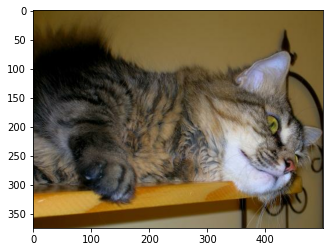

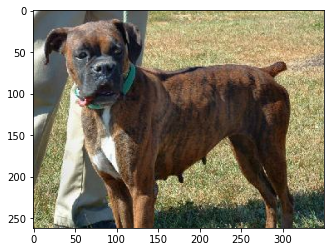

In [14]:
import matplotlib.pyplot as plt


for cls in (0, 1):
  for image, label in raw_train:
    if label == cls:
      plt.figure()
      plt.imshow(image)
      break

These are color images with noisy backgrounds. Also, the images aren't the same size, so we'll need to eventually resize them to feed our model.

Let's find the range of color values and image sizes.

In [15]:
import sys 

global_min = sys.maxsize 
global_max = -sys.maxsize-1
sizes = collections.defaultdict(int)

for split in (raw_train, raw_validation, raw_test):
  for image, _ in split:
    local_max = image.numpy().max()
    local_min = image.numpy().min()
    sizes[image.numpy().shape] += 1

    if local_max > global_max:
      global_max = local_max
    
    if local_min < global_min:
      global_min = local_min

print(f"Color values range from {global_min} to {global_max}")
resolutions = [x[0] for x in sorted(sizes.items(), key=lambda r: r[0])]
print(f"There are {len(resolutions)} resolutions ranging from ",
      f"{resolutions[0]} to {resolutions[-1]}")


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Color values range from 0 to 255
There are 6462 resolutions ranging from  (4, 4, 3) to (500, 500, 3)


It looks like we are dealing with color values from `0` through `255`, which is pretty standard.

We have a huge number of different resolutions. There are over `6,000` different image sizes in this dataset, some as small as `4x4x3`! It is difficult to imagine that an image that small would be meaningful. Let's see how many tiny images we are dealing with.


In [16]:
for resolution in sorted(sizes.items(), key=lambda r: r[0])[:10]:
  print(resolution[0], ': ', resolution[1])

(4, 4, 3) :  1
(33, 60, 3) :  1
(36, 60, 3) :  1
(37, 100, 3) :  1
(39, 60, 3) :  1
(41, 60, 3) :  1
(45, 60, 3) :  2
(47, 65, 3) :  1
(48, 60, 3) :  1
(50, 50, 3) :  2


There is only one truly tiny image. Let's take a look at it.

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


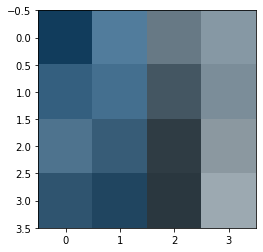

In [17]:
shown = False
for split in (raw_train, raw_validation, raw_test):
  if shown:
    break
  for image, _ in split:
    if image.numpy().shape == (4, 4, 3):
      plt.figure()
      plt.imshow(image)
      shown = True
      break

That's definitely bad data. Let's go ahead and sample some of the other small images.

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


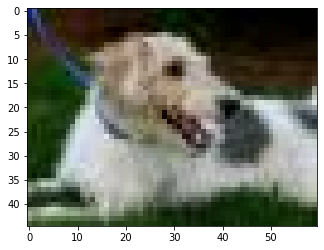

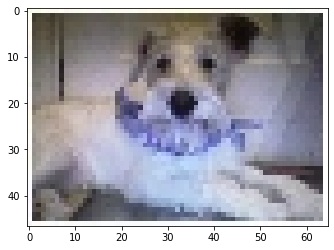

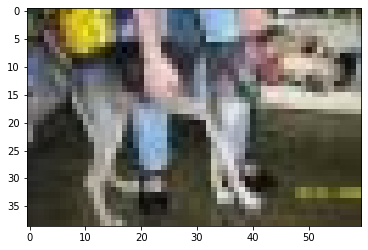

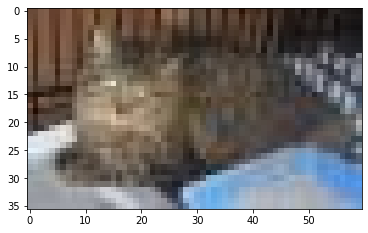

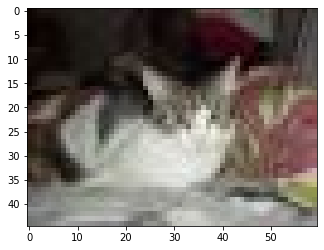

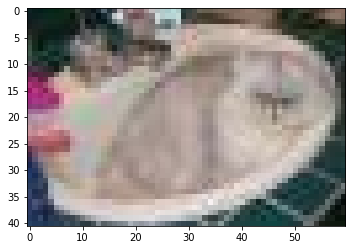

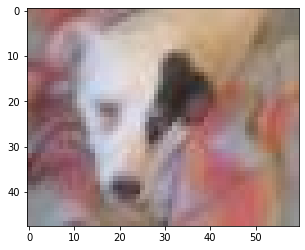

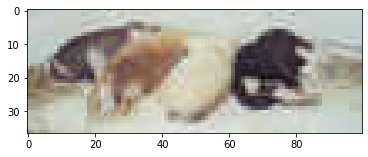

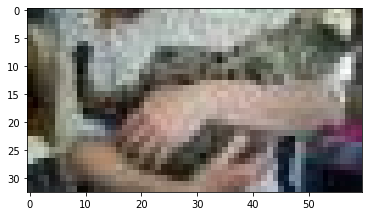

In [18]:
for split in (raw_train, raw_validation, raw_test):
  for image, _ in split:
    if image.numpy().shape[0] < 50 and image.numpy().shape[0] > 4:
      plt.figure()
      plt.imshow(image)      

Though some are difficult to interpret, you can probably tell that each image contains either cats or dogs.

In order to not process the tiny image, we can write a filter function. We know the shape is `(4, 4, 3)`, so we can filter for that exact shape. To make the filter a little more generic, we'll instead filter out any image that is shorter or narrower than `6` pixels.

In [19]:
import tensorflow as tf

def filter_out_small(image, _):
  return tf.math.reduce_any(tf.shape(image)[0] > 5 and tf.shape(image)[1] > 5)

for s in (
    ("Train", raw_train.filter(filter_out_small)),
    ("Validation", raw_validation.filter(filter_out_small)),
    ("Test", raw_test.filter(filter_out_small))):
  print(s[0])
  split_details(s[1])
  print()

Train


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


Class dog: 9232
Class cat: 9378
Total: 18610

Validation


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


Class dog: 1206
Class cat: 1120
Total: 2326

Test


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Class cat: 1159
Class dog: 1166
Total: 2325



It looks like our problematic image was a cat in the holdout test set.

## The Pretrained Model

To build our cat/dog classifier, we'll use the learnings of a pre-trained model. Specifically [`MobileNetV2`](https://arxiv.org/abs/1801.04381). We'll use [`tf.keras.applications.MobileNetV2`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2) to load the data.

### Model-Specific Preprocessing

[Researching `MobileNetV2`](https://arxiv.org/pdf/1801.04381.pdf), you'll find that the neural network by default takes an input of image of size `(224, 224, 3)`. Though the model can be configured to take other inputs, all of our images are different sizes. So we might as well resize them to fit the default.

In [20]:
IMG_SIZE = 224 

def resize_images(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

train_resized = raw_train.map(resize_images)
validation_resized = raw_validation.map(resize_images)
test_resized = raw_test.map(resize_images)

We also need to normalize our data, but what should our input values be scaled to? Ideally our input data should look like the input data that the `MobileNetV2` was trained on. Unfortunately, this isn't published.

`MobileNetV2` [internally](https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet_v2.py) uses [`relu6`](https://www.tensorflow.org/api_docs/python/tf/nn/relu6), which limits activation outputs to the range of `0` through `6`. This hints that we might want to normalize our values between `[0, 1]` or even `[0, 6]`.

It also performs **batch normalization** throughout the network. This is the process of dividing input values by the mean and subtracting the standard deviation of each batch of data processed. So "batch normalization" is really "batch standardization".

Standardizing our data by batch is possible. We could also calculate the mean and standard deviation of all of the data and standardize the entire dataset in one pass. Or we could *approximate* standardization and simply divide our input data by `127.5` (the midpoint of our `[0, 255]` range) and then subtract `1` (a guessed standard deviation).

In [21]:
def standardize_images(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

train_standardized = train_resized.map(standardize_images)
validation_standardized = validation_resized.map(standardize_images)
test_standardized = test_resized.map(standardize_images)

Did it work? Let's check it out.

In [22]:
import sys 

global_min = sys.maxsize 
global_max = -sys.maxsize-1
sizes = collections.defaultdict(int)

for split in (train_standardized, validation_standardized, test_standardized):
  for image, _ in split:
    local_max = image.numpy().max()
    local_min = image.numpy().min()
    sizes[image.numpy().shape] += 1

    if local_max > global_max:
      global_max = local_max
    
    if local_min < global_min:
      global_min = local_min

print(f"Color values range from {global_min} to {global_max}")
resolutions = [x[0] for x in sorted(sizes.items(), key=lambda r: r[0])]
print(f"There are {len(resolutions)} resolutions ranging from ",
      f"{resolutions[0]} to {resolutions[-1]}")


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Color values range from -1.0 to 1.0
There are 1 resolutions ranging from  (224, 224, 3) to (224, 224, 3)


Looks great! Now it is time to load our pretrained model.

### Loading MobileNetV2

Loading `MobileNetV2` is pretty straight-forward.

We need to pass in the input shape, which is `(224, 224, 3)` for each image.

We also include pre-trained weights based on [`ImageNet`](http://www.image-net.org/). This is where the transfer learning comes in. `ImageNet` has over a million images that map to a thousand labels. `MobileNetV2` has been trained on `ImageNet`. We'll use those learnings and then add a few more layers of our own model to build a cat/dog classifier.

The final argument is `include_top`. Typically when building a classification model, toward the end of the model, high-dimensional layers are flattened down into two-dimensional tensors. This is considered the top of the model since diagrams often show the final layers at the top. For transfer learning we'll leave this dimensionality reduction off.

If you do include the top of the model, the following extra layers will be shown:

```text    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1280)         0           out_relu[0][0]                   
__________________________________________________________________________________________________
predictions (Dense)             (None, 1000)         1281000     global_average_pooling2d_1[0][0] 
```

In [23]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

mnv2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                         weights='imagenet',
                                         include_top=False)

mnv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

It is often a good idea to "freeze" the trained model. This prevents its weights from being updated when we train our new model.

It is really only recommended to update the weights of the pretrained model when you are about to train on a large and similar dataset, as compared to the one that was originally trained on. This is not the case in our example. `ImageNet` has a thousand classes and over a million images. We have two classes and a few thousand images.

In [24]:
mnv2.trainable = False

### Batching

We will want to train our model in batches. In our case we'll use a batch size of `32`. You might want to experiment with other sizes.

In [25]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train_standardized.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation_standardized.batch(BATCH_SIZE)
test_batches = test_standardized.filter(filter_out_small).batch(BATCH_SIZE)

You can see that we now have a well-defined input shape for each training batch.

In [26]:
image_batch, label_batch = next(iter(train_batches.take(1)))

image_batch.shape

TensorShape([32, 224, 224, 3])

If we apply our model to our first batch, you can see that we get a `(32, 7, 7, 1280)` block of features. These will be the input to our cat/dog model.

In [27]:
feature_batch = mnv2(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


### Extending the Model

Now we can perform the actual transfer learning. We'll build a new model that classifies images as containing dogs or cats. In order to do that, we can use a `Sequential` model with the pretrained model as the first layer.

Note that the output layer of our pretrained model is:

```text
out_relu (ReLU)                 (None, 7, 7, 1280)   0           Conv_1_bn[0][0]  
```

Since the activation function is `relu6`, we know that the data that we'll be receiving is in the range of `[0, 6]`. We apply a pooling layer to reduce our inputs. In our output layer, we distill the inputs down to a single number that indicates if the image is of a cat or dog. We chose the sigmoid function, which will cause the output to be in a range of `[0, 1]`. This represents the confidence in an image being a dog, since dog is encoded as `1`.



In [28]:
model = tf.keras.Sequential([
  mnv2,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


We now compile the model, training for accuracy with binary cross entropy used to calculate loss.

In [29]:
model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


Training will take a few minutes. Be sure to use GPU or it will take a really long time.

In [30]:
history = model.fit(
  train_batches,
  epochs=10,
  validation_data=validation_batches
)

Epoch 1/10
164/582 [=======>......................] - ETA: 2:24 - loss: 0.1034 - accuracy: 0.9688

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 2:13 - loss: 0.0951 - accuracy: 0.9713

206/582 [=========>....................] - ETA: 2:09 - loss: 0.0935 - accuracy: 0.9718

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 1:44 - loss: 0.0817 - accuracy: 0.9748

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 33s - loss: 0.0633 - accuracy: 0.9805

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 28s - loss: 0.0625 - accuracy: 0.9807

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 24s - loss: 0.0615 - accuracy: 0.9811

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 15s - loss: 0.0597 - accuracy: 0.9816

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 13s - loss: 0.0592 - accuracy: 0.9818

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9821

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 236s 401ms/step - loss: 0.0578 - accuracy: 0.9821 - val_loss: 0.0439 - val_accuracy: 0.9854
Epoch 2/10
163/582 [=======>......................] - ETA: 2:20 - loss: 0.0342 - accuracy: 0.9873

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


195/582 [=========>....................] - ETA: 2:10 - loss: 0.0343 - accuracy: 0.9880

205/582 [=========>....................] - ETA: 2:08 - loss: 0.0351 - accuracy: 0.9877

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/582 [=============>................] - ETA: 1:44 - loss: 0.0340 - accuracy: 0.9876

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


485/582 [========================>.....] - ETA: 32s - loss: 0.0311 - accuracy: 0.9890

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


498/582 [========================>.....] - ETA: 28s - loss: 0.0317 - accuracy: 0.9890

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


509/582 [=========================>....] - ETA: 24s - loss: 0.0317 - accuracy: 0.9890

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


536/582 [==========================>...] - ETA: 15s - loss: 0.0312 - accuracy: 0.9892

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


542/582 [==========================>...] - ETA: 13s - loss: 0.0314 - accuracy: 0.9890

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9892

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0308 - accuracy: 0.9892 - val_loss: 0.0365 - val_accuracy: 0.9875
Epoch 3/10
164/582 [=======>......................] - ETA: 2:23 - loss: 0.0298 - accuracy: 0.9907

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 2:13 - loss: 0.0294 - accuracy: 0.9906

206/582 [=========>....................] - ETA: 2:10 - loss: 0.0288 - accuracy: 0.9907

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 1:45 - loss: 0.0297 - accuracy: 0.9908

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 33s - loss: 0.0284 - accuracy: 0.9913

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 28s - loss: 0.0281 - accuracy: 0.9914

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 25s - loss: 0.0276 - accuracy: 0.9916

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 15s - loss: 0.0272 - accuracy: 0.9917

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 13s - loss: 0.0271 - accuracy: 0.9917

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9915

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 403ms/step - loss: 0.0268 - accuracy: 0.9915 - val_loss: 0.0372 - val_accuracy: 0.9884
Epoch 4/10
164/582 [=======>......................] - ETA: 2:28 - loss: 0.0262 - accuracy: 0.9909

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 2:17 - loss: 0.0249 - accuracy: 0.9914

206/582 [=========>....................] - ETA: 2:13 - loss: 0.0244 - accuracy: 0.9915

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 1:48 - loss: 0.0274 - accuracy: 0.9904

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 34s - loss: 0.0252 - accuracy: 0.9917

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 30s - loss: 0.0255 - accuracy: 0.9916

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 26s - loss: 0.0251 - accuracy: 0.9918

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 16s - loss: 0.0244 - accuracy: 0.9920

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 14s - loss: 0.0244 - accuracy: 0.9921

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9920

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 245s 420ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0378 - val_accuracy: 0.9871
Epoch 5/10
163/582 [=======>......................] - ETA: 2:28 - loss: 0.0250 - accuracy: 0.9923

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


195/582 [=========>....................] - ETA: 2:17 - loss: 0.0256 - accuracy: 0.9920

205/582 [=========>....................] - ETA: 2:14 - loss: 0.0253 - accuracy: 0.9921

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/582 [=============>................] - ETA: 1:49 - loss: 0.0256 - accuracy: 0.9919

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


485/582 [========================>.....] - ETA: 34s - loss: 0.0241 - accuracy: 0.9928

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


498/582 [========================>.....] - ETA: 29s - loss: 0.0236 - accuracy: 0.9930

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


509/582 [=========================>....] - ETA: 25s - loss: 0.0232 - accuracy: 0.9931

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


536/582 [==========================>...] - ETA: 16s - loss: 0.0230 - accuracy: 0.9931

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


542/582 [==========================>...] - ETA: 14s - loss: 0.0235 - accuracy: 0.9928

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 239s 411ms/step - loss: 0.0225 - accuracy: 0.9932 - val_loss: 0.0381 - val_accuracy: 0.9884
Epoch 6/10
164/582 [=======>......................] - ETA: 2:57 - loss: 0.0230 - accuracy: 0.9929

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 2:44 - loss: 0.0246 - accuracy: 0.9930

206/582 [=========>....................] - ETA: 2:40 - loss: 0.0258 - accuracy: 0.9929

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 2:09 - loss: 0.0233 - accuracy: 0.9935

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 40s - loss: 0.0222 - accuracy: 0.9931

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 35s - loss: 0.0219 - accuracy: 0.9932

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 30s - loss: 0.0218 - accuracy: 0.9933

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 18s - loss: 0.0216 - accuracy: 0.9933

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 16s - loss: 0.0216 - accuracy: 0.9933

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9935

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 276s 473ms/step - loss: 0.0213 - accuracy: 0.9935 - val_loss: 0.0394 - val_accuracy: 0.9880
Epoch 7/10
163/582 [=======>......................] - ETA: 2:31 - loss: 0.0229 - accuracy: 0.9929

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


195/582 [=========>....................] - ETA: 2:19 - loss: 0.0234 - accuracy: 0.9929

205/582 [=========>....................] - ETA: 2:17 - loss: 0.0228 - accuracy: 0.9931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/582 [=============>................] - ETA: 1:53 - loss: 0.0235 - accuracy: 0.9935

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


485/582 [========================>.....] - ETA: 36s - loss: 0.0217 - accuracy: 0.9935

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


498/582 [========================>.....] - ETA: 31s - loss: 0.0217 - accuracy: 0.9934

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


509/582 [=========================>....] - ETA: 27s - loss: 0.0213 - accuracy: 0.9936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


536/582 [==========================>...] - ETA: 17s - loss: 0.0208 - accuracy: 0.9938

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


542/582 [==========================>...] - ETA: 14s - loss: 0.0206 - accuracy: 0.9938

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9939

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 248s 426ms/step - loss: 0.0199 - accuracy: 0.9939 - val_loss: 0.0396 - val_accuracy: 0.9884
Epoch 8/10
163/582 [=======>......................] - ETA: 2:26 - loss: 0.0195 - accuracy: 0.9933

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


195/582 [=========>....................] - ETA: 2:15 - loss: 0.0213 - accuracy: 0.9931

205/582 [=========>....................] - ETA: 2:11 - loss: 0.0216 - accuracy: 0.9933

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/582 [=============>................] - ETA: 1:46 - loss: 0.0221 - accuracy: 0.9932

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


485/582 [========================>.....] - ETA: 33s - loss: 0.0209 - accuracy: 0.9937

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


498/582 [========================>.....] - ETA: 28s - loss: 0.0205 - accuracy: 0.9939

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


509/582 [=========================>....] - ETA: 25s - loss: 0.0201 - accuracy: 0.9940

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


536/582 [==========================>...] - ETA: 15s - loss: 0.0195 - accuracy: 0.9942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


542/582 [==========================>...] - ETA: 13s - loss: 0.0199 - accuracy: 0.9939

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9943

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 395ms/step - loss: 0.0191 - accuracy: 0.9943 - val_loss: 0.0403 - val_accuracy: 0.9884
Epoch 9/10
164/582 [=======>......................] - ETA: 2:21 - loss: 0.0207 - accuracy: 0.9931

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 2:11 - loss: 0.0219 - accuracy: 0.9930

206/582 [=========>....................] - ETA: 2:07 - loss: 0.0211 - accuracy: 0.9933

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 1:43 - loss: 0.0200 - accuracy: 0.9940

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 32s - loss: 0.0195 - accuracy: 0.9942

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 28s - loss: 0.0196 - accuracy: 0.9941

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 24s - loss: 0.0194 - accuracy: 0.9941

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 15s - loss: 0.0188 - accuracy: 0.9942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 13s - loss: 0.0186 - accuracy: 0.9942

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9945

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0180 - accuracy: 0.9945 - val_loss: 0.0434 - val_accuracy: 0.9862
Epoch 10/10
163/582 [=======>......................] - ETA: 2:23 - loss: 0.0195 - accuracy: 0.9935

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


195/582 [=========>....................] - ETA: 1:40:54 - loss: 0.0197 - accuracy: 0.9939

205/582 [=========>....................] - ETA: 1:33:42 - loss: 0.0205 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/582 [=============>................] - ETA: 1:20:45 - loss: 0.0202 - accuracy: 0.9941

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 22:18 - loss: 0.0189 - accuracy: 0.9943

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 18:49 - loss: 0.0186 - accuracy: 0.9945

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 15:59 - loss: 0.0184 - accuracy: 0.9945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 17:07 - loss: 0.0184 - accuracy: 0.9945

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 14:40 - loss: 0.0183 - accuracy: 0.9945

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9948 

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 12361s 21s/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.0417 - val_accuracy: 0.9884


We got a training accuracy of over `99%` and a validation accuracy close to `99%`! Let's graph the accuracy and loss per epoch.

Text(0.5, 0, 'epoch')

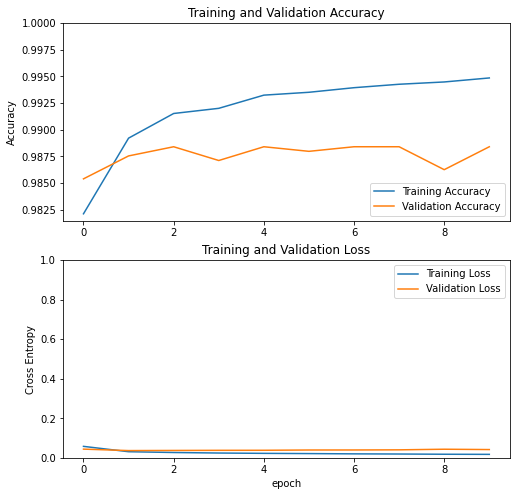

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

The graph makes it look like we might be overfitting, but if you look at the range on the y-axis, we actually aren't doing too badly. We should, however, perform a final test to see if we can generalize well.

In [32]:
model.evaluate(test_batches)

     27/Unknown - 153s 6s/step - loss: 0.0311 - accuracy: 0.9942

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 2000s 28s/step - loss: 0.0226 - accuracy: 0.9914


[0.022578934207558632, 0.9914015531539917]

We got an accuracy of just over `99%`, which can give us some confidence that this model generalizes well.

### Making Predictions

We can use the model to make predictions by using the `predict()` function.

In [33]:
predictions = model.predict(test_batches)

predictions.min(), predictions.max()

     27/Unknown - 19s 700ms/step

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 7257s 101s/step


(3.178693e-10, 1.0)

Remember the predictions can range from `0.0` to `1.0`. We can round them and cast them to integers to get class mappings.

In [34]:
import numpy as np

predictions = np.round(predictions.flatten(), 0).astype(np.int)
predictions

/var/folders/40/28srkw8j0d53sp2bwbx3h8h00000gn/T/ipykernel_2129/1169081142.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.round(predictions.flatten(), 0).astype(np.int)


array([0, 1, 1, ..., 0, 1, 0])

And we can now print the predicted class alongside the original image.

cat


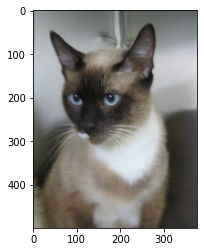

In [35]:
print(get_class_name(predictions[0]))
_ = plt.imshow(next(iter(raw_test.take(1)))[0].numpy())

You can also make predictions by calling the model directly and passing it a single batch.

cat


/var/folders/40/28srkw8j0d53sp2bwbx3h8h00000gn/T/ipykernel_2129/3377463501.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.round(predictions, 0).astype(np.int).flatten()


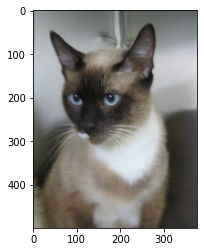

In [38]:
predictions = model(next(iter(test_batches))[0]) ## FIXED: Added a zero subscript
predictions = np.round(predictions, 0).astype(np.int).flatten()

print(get_class_name(predictions[0]))
_ = plt.imshow(next(iter(raw_test.take(1)))[0].numpy())

# Exercises

## Exercise 1: Food 101

In this exercise you'll build a classifier for the [Food 101](https://www.tensorflow.org/datasets/catalog/food101) dataset. The classifier will transfer learnings from [`DenseNet201`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/DenseNet201).

In order to complete the exercise, you will need to:
* Load the [Food 101](https://www.tensorflow.org/datasets/catalog/food101) dataset. *Be sure to pay attention to the splits!*
* Perform exploratory data analysis on the dataset.
* Ensure every class is represented in your train, test, and validation splits of the dataset.
* Normalize or standardize your data in the way that the model was trained. *You can find this information in the [paper introducing the model](https://arxiv.org/pdf/1608.06993.pdf).*
* Extend [`DenseNet201`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/DenseNet201) with a new model, and have it classify the `101` food types. *Note that [`one_hot`](https://www.tensorflow.org/api_docs/python/tf/one_hot) and [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) can help you manipulate the targets to make the model train faster.*
* Graph training accuracy and loss.
* Calculate accuracy and loss for your holdout test set.*
* Make predictions and print out one predicted label and original image.

> **Don't sweat too much about your model's performance. We were only able to get about `75%` training accuracy (with obvious overfitting) in our naive model after `10` training epochs. This model is trying to classify `101` different things with messy images. Don't expect it to perform anywhere close to our binary model above.*

Use as many code and text cells as you need to complete this task. Explain your work.

### **Student Solution**

In [ ]:
# Your Solution Goes Here

---